In [1]:
from chromo import models as im
from chromo.kinematics import CenterOfMass
from chromo.constants import GeV
from chromo.util import get_all_models
from chromo.common import CrossSectionData

# from util import run_in_separate_process
from particle import literals as lp
import numpy as np
from matplotlib import pyplot as plt
import joblib

In [2]:
energies = np.geomspace(10, 100000, 20) * GeV


@joblib.delayed
def run(Model):
    values = []
    m = Model(CenterOfMass(energies[-1], "p", "p"))
    for en in energies:
        kin = CenterOfMass(en, "p", "p")
        c = m.cross_section(kin)
        values.append(c)
    return values


Models = [
    M
    for M in get_all_models()
    if lp.proton.pdgid in M.projectiles and lp.proton.pdgid in M.targets
]
cross_sections = {}
out = joblib.Parallel(len(Models), batch_size=1)(run(Model) for Model in Models)
for Model, o in zip(Models, out):
    cross_sections[Model.pyname] = o

 +-----------------------------------------------------------------------+
 |                                                                       |
 |                          DPMJET version 3.0-7                         |
 |                                                                       |
 |                      (Last change: 23 Aug 2023)                       |
 |                                                                       |
 |            Authors: Stefan Roesler   (CERN)                           |
 |                     Ralph Engel      (FZ Karlsruhe)                   |
 |                     Johannes Ranft   (Siegen Univ.)                   |
 |                                                                       |
 +-----------------------------------------------------------------------+
 | Please send suggestions, bug reports, etc. to: Stefan.Roesler@cern.ch |
 +-----------------------------------------------------------------------+


Warning!  No evaporatio

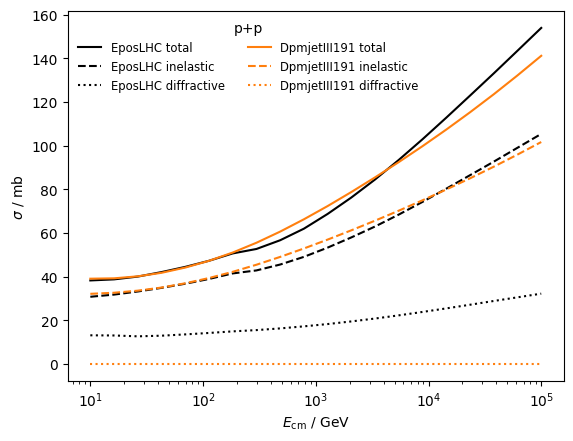

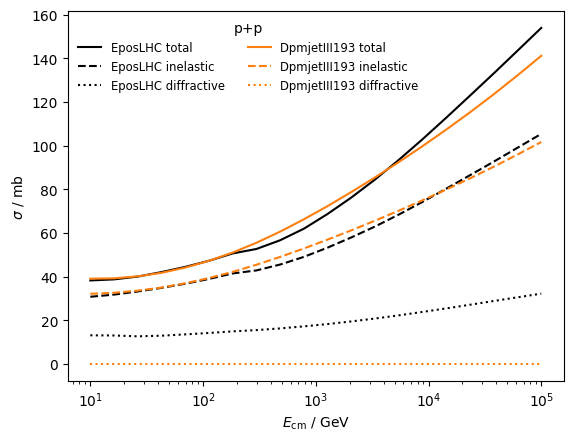

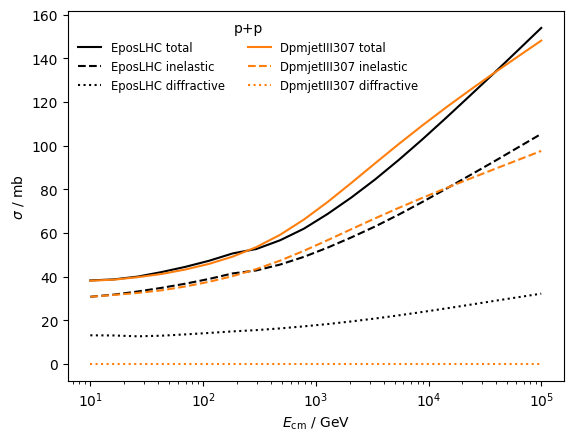

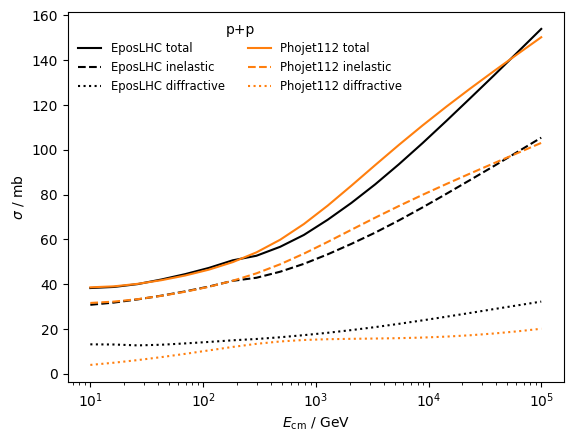

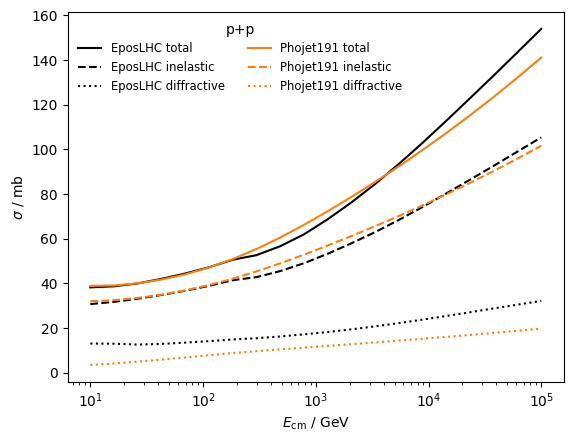

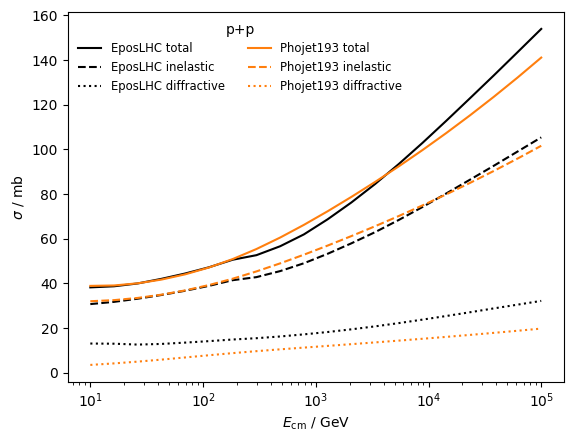

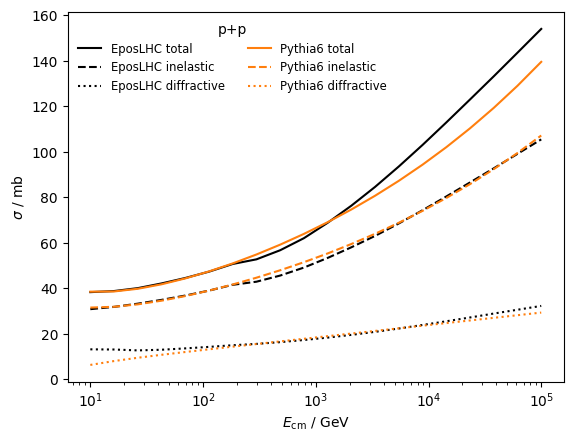

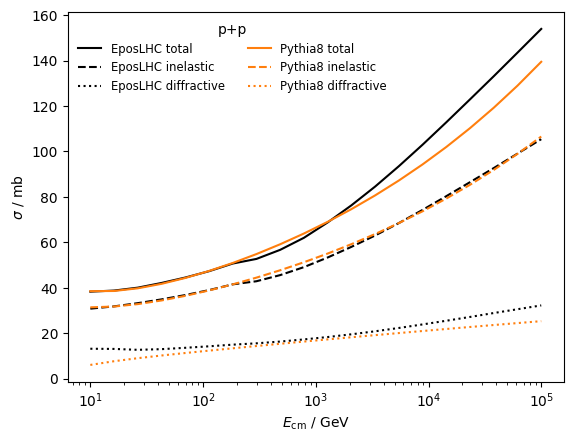

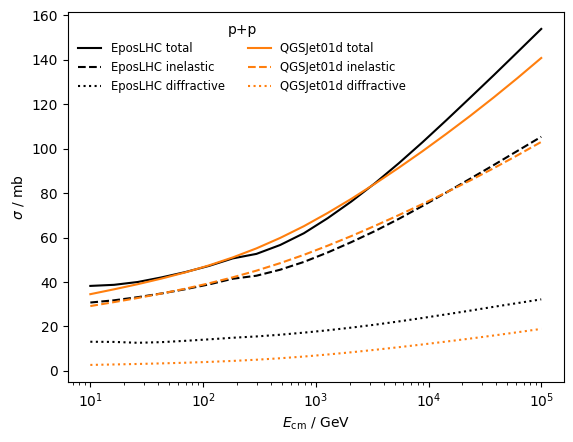

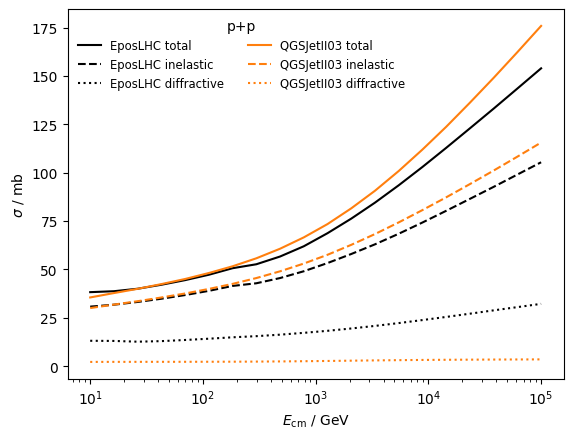

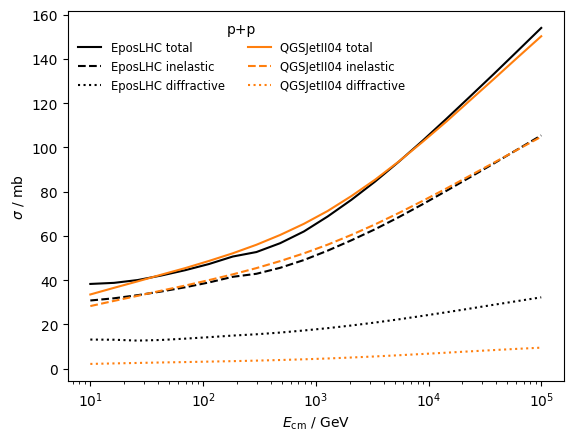

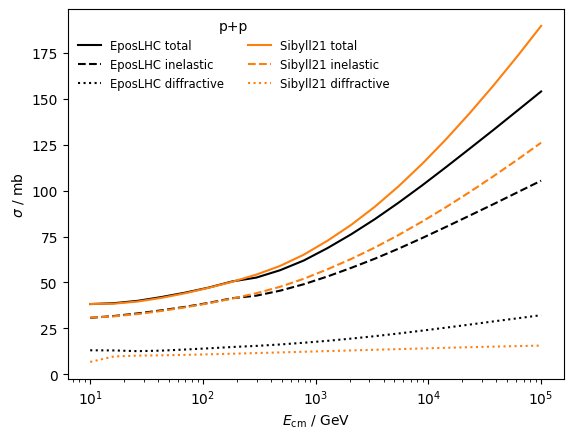

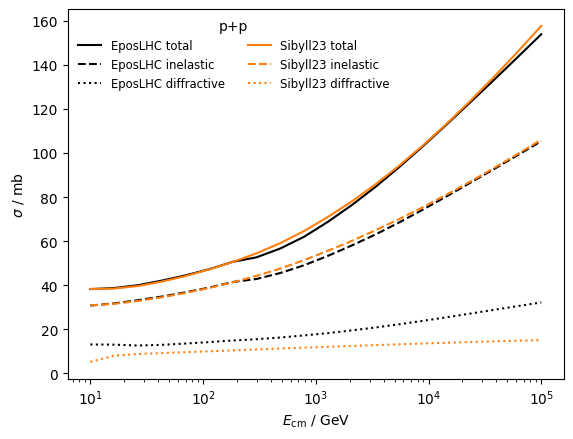

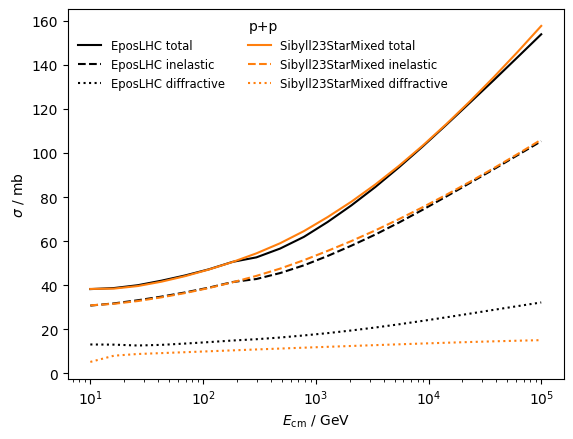

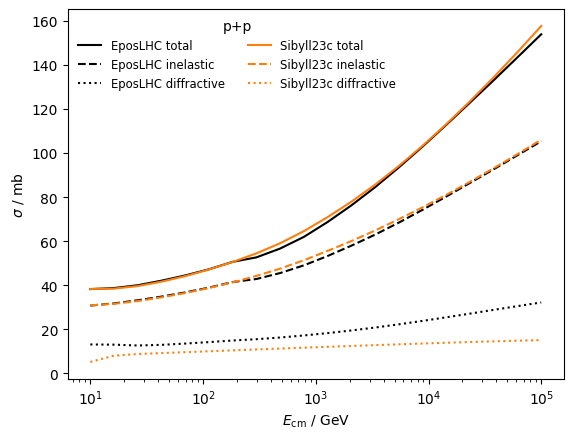

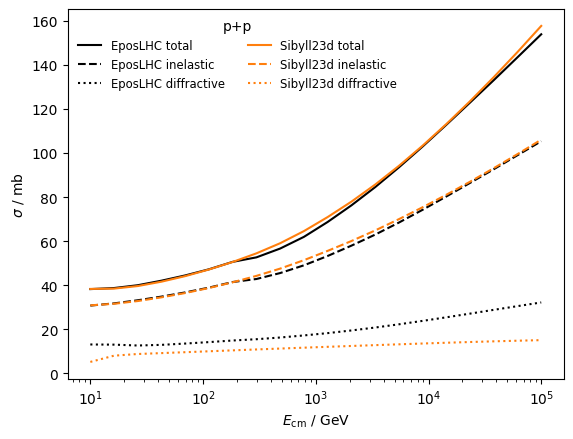

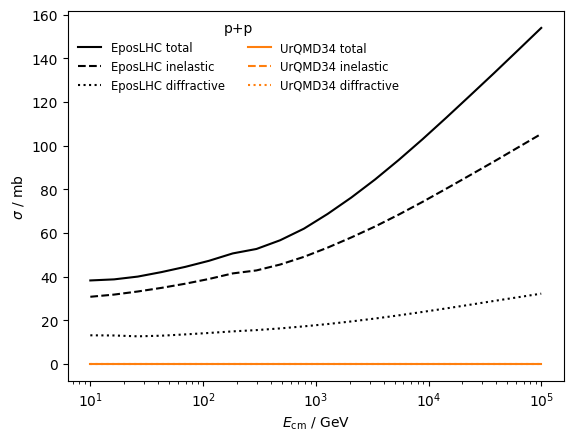

In [3]:
import dataclasses

reference_model = "EposLHC"

for model in cross_sections:
    if model == reference_model:
        continue
    plt.figure()
    kinds = "total", "inelastic", "diffractive"
    for k, model2 in enumerate((reference_model, model)):
        data = cross_sections[model2]
        for i, kind in enumerate(kinds):
            val = [getattr(d, kind) for d in data]

            if np.any(val != 0):
                plt.plot(
                    energies / GeV,
                    val,
                    label=model2 + " " + kind,
                    ls=["-", "--", ":"][i],
                    color=["k", "C1"][k],
                    zorder=1 + k,
                )
    plt.semilogx()
    plt.legend(frameon=False, ncol=2, fontsize="small", title="p+p")
    plt.xlabel("$E_\\mathrm{cm}$ / GeV")
    plt.ylabel(r"$\sigma$ / mb")